<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Compare_Diag_Jacobians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
Jdir =  '/content/drive/My Drive/jacobians'

In [0]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [0]:
!pip install pytorchcv

In [0]:
!pip install powerlaw

In [0]:
import os
import time

import math
import copy
import glob

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import powerlaw





In [0]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

modelnames = ["resnet20_cifar10", "resnet56_cifar10", "resnet110_cifar10", "resnet164bn_cifar10", "resnet272bn_cifar10", "resnet542bn_cifar10"]

for name in modelnames:
  fullglob = Jdir+"/Jdiag_"+name+"_*.csv"
  print(name, len(glob.glob(fullglob)))

resnet20_cifar10 10
resnet56_cifar10 10
resnet110_cifar10 10
resnet164bn_cifar10 10
resnet272bn_cifar10 50
resnet542bn_cifar10 50


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


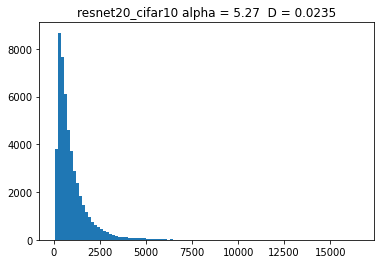

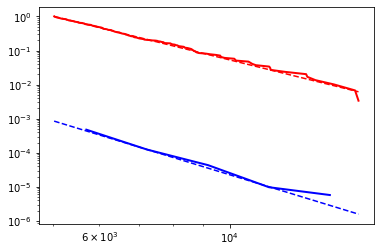

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


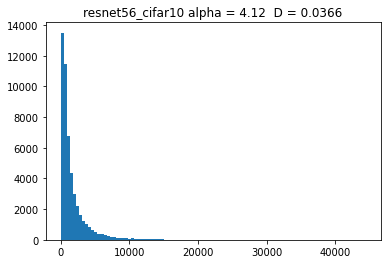

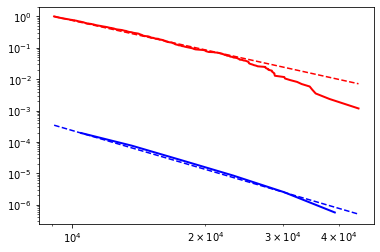

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


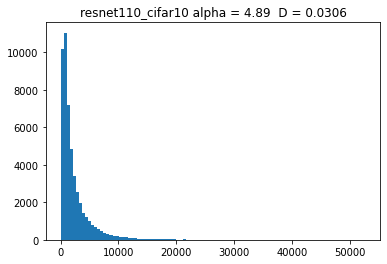

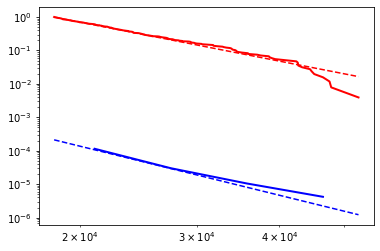

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


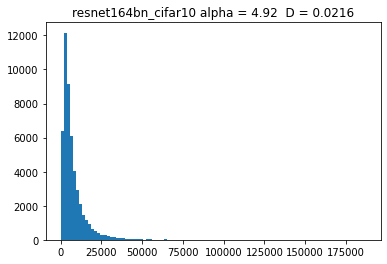

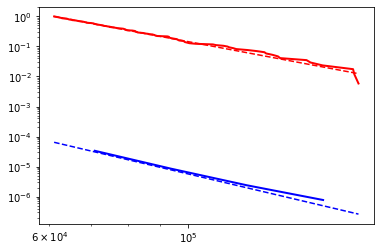

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


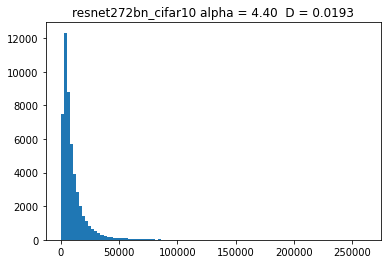

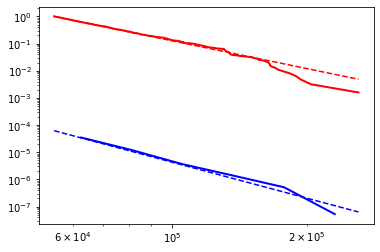

Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


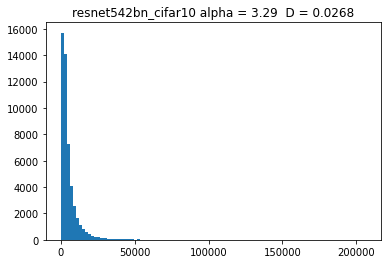

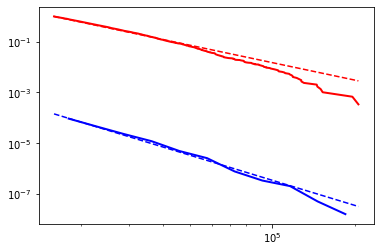

In [0]:
import numpy as np

model_alphas = []
model_maxlogJJs = []
for name in modelnames:
  fullglob = Jdir+"/Jdiag_"+name+"_*.csv"
  Jdiag = []
  for fname in glob.glob(fullglob):
    Jdiag.extend(np.loadtxt(fname))

  fit = powerlaw.Fit(Jdiag)
  alpha = fit.power_law.alpha
  D = fit.power_law.D
  title = "{} alpha = {:04.2f}  D = {:04.4f}".format(name, alpha, D)

  model_alphas.append(alpha)

  model_maxlogJJs.append(np.log10(np.max(Jdiag)))

  plt.hist(Jdiag, bins=100)
  plt.title(title)
  plt.show()

  fig2 = fit.plot_pdf(color='b', linewidth=2)
  fit.power_law.plot_pdf(color='b', linestyle='--', ax=fig2)
  fit.plot_ccdf(color='r', linewidth=2, ax=fig2)
  fit.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
  plt.show()
  

### Look at long tail data points

- are they conserved across runs. NOT At ALL


In [0]:
a = [1,2,3,4,5]
np.array(a).argsort()[-3:][::-1]

array([4, 3, 2])

In [0]:

for name in modelnames:
  fullglob = Jdir+"/Jdiag_"+name+"_*.csv"
  Jdiag = []
  for fname in glob.glob(fullglob):
    Jdiag.extend(np.loadtxt(fname))

  topN = np.array(Jdiag).argsort()[-5:]
  maxlogJJ = np.log10(np.max(Jdiag))

  print(name, topN, maxlogJJ)


resnet20_cifar10 [12469 33428 23016 27867 41434] 4.2191290153219345
resnet56_cifar10 [31714 33471 32483 19347  3549] 4.647184163365722
resnet110_cifar10 [ 6073 27331  3331 48063 14373] 4.72107017206197
resnet164bn_cifar10 [23472 39502   134 38553  6344] 5.271654211298726
resnet272bn_cifar10 [21630 24708 18807 34317 27596] 5.416947218284522
resnet542bn_cifar10 [27647 12271 29387  1266 15904] 5.314163423861337


### Evaluation of the models

In [0]:
import logging
import os

import numpy as np
import torch
from torch.autograd import Variable


In [0]:
def get_data(batch_size=100, train_range=None, test_range=None):
  normalize = transforms.Normalize(mean=[x/255.0 for x in [125.3, 123.0, 113.9]], std=[x / 255.0 for x in [63.0, 62.1, 66.7]])
  transform_train = transforms.Compose([
          transforms.ToTensor(),
          normalize])
  transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize])
  train_dataset = datasets.CIFAR10(root='data', 
                                train=True, 
                                transform=transform_train,
                                download=True)
  test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transform_test,
                                download=True)  
  
  if train_range:
      train_dataset = torch.utils.data.Subset(train_dataset, train_range)

  if test_range:
      teat_dataset = torch.utils.data.Subset(test_dataset, test_range)


  train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size,
                          num_workers=4,
                          shuffle=False)
  test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size,
                         num_workers=4,
                         shuffle=False)
  return train_dataset, test_dataset, train_loader, test_loader



In [0]:
train_dataset, test_dataset, train_loader, test_loader = get_data(batch_size=100)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
def evaluate(model, dataloader):

    model.to('cuda:0')
    model.eval()

    correct = 0
     # compute metrics over the dataset
    for data, labels in dataloader:
        data, labels = data.to('cuda:0'), labels.to('cuda:0')
        data, labels = Variable(data), Variable(labels)
        
        # compute model output
        output = model(data)

        # extract data from torch Variable, move to cpu, convert to numpy arrays
        output = output.data.cpu().numpy()
        labels = labels.data.cpu().numpy()

        correct += np.sum([np.argmax(output[i])==labels[i] for i in range(len(labels))])
        
    accuracy = 100 * correct / len(dataloader)
    return accuracy


In [0]:
model_accs = []
for modelname in pytorchcv.model_provider._models.keys():
    if modelname in modelnames:
        model = ptcv_get_model(modelname, pretrained=True)
        acc = 100.0* evaluate(model, test_loader) / 10000
        print(modelname, acc)
        model_accs.append(acc)

resnet20_cifar10 93.9
resnet56_cifar10 95.32
resnet110_cifar10 96.26
resnet164bn_cifar10 96.24
resnet272bn_cifar10 96.63
resnet542bn_cifar10 96.52


### Compare Accuracy to Alpha

### What do the training data points look like ?




In [0]:
for name, acc, alpha in zip(modelnames, model_accs, model_alphas):
  print(name, acc, alpha)

resnet20_cifar10 93.9 5.266854227803314
resnet56_cifar10 95.32 4.119533016371639
resnet110_cifar10 96.26 4.887086723168496
resnet164bn_cifar10 96.24 4.922533048335661
resnet272bn_cifar10 96.63 4.398053847822205
resnet542bn_cifar10 96.52 3.2869902842560044


resnet20_cifar10 93.9 5.266854227803314
resnet56_cifar10 95.32 4.119533016371639
resnet110_cifar10 96.26 4.887086723168496
resnet164bn_cifar10 96.24 4.922533048335661
resnet272bn_cifar10 96.63 4.398053847822205
resnet542bn_cifar10 96.52 3.2869902842560044


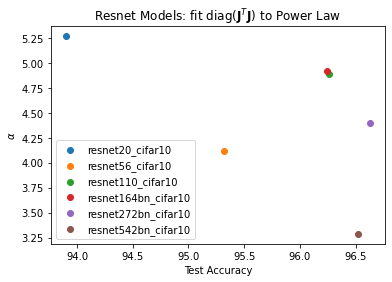

In [0]:
for name, acc, alpha in zip(modelnames, model_accs, model_alphas):
  print(name, acc, alpha)
  plt.scatter(acc, alpha, label=name)
plt.xlabel("Test Accuracy")
plt.ylabel(r"$\alpha$")
plt.title(r"Resnet Models: fit diag($\mathbf{J}^{T}\mathbf{J}$) to Power Law ")
plt.legend()

resnet20_cifar10 93.9 5.266854227803314
resnet56_cifar10 95.32 4.119533016371639
resnet110_cifar10 96.26 4.887086723168496
resnet164bn_cifar10 96.24 4.922533048335661
resnet272bn_cifar10 96.63 4.398053847822205
resnet542bn_cifar10 96.52 3.2869902842560044


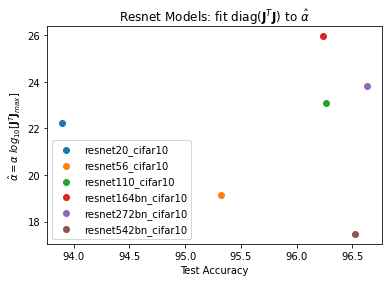

In [0]:
for name, acc, alpha, logJJmax in zip(modelnames, model_accs, model_alphas, model_maxlogJJs):
  print(name, acc, alpha)
  plt.scatter(acc, alpha*logJJmax, label=name)
plt.xlabel("Test Accuracy")
plt.ylabel(r"$\hat{\alpha}={\alpha}\;log_{10}[\mathbf{J}^{T}\mathbf{J}_{max}]$")
plt.title(r"Resnet Models: fit diag($\mathbf{J}^{T}\mathbf{J}$) to $\hat{\alpha}$ ")
plt.legend()

resnet20_cifar10 93.9 5.266854227803314
resnet56_cifar10 95.32 4.119533016371639
resnet110_cifar10 96.26 4.887086723168496
resnet164bn_cifar10 96.24 4.922533048335661
resnet272bn_cifar10 96.63 4.398053847822205
resnet542bn_cifar10 96.52 3.2869902842560044


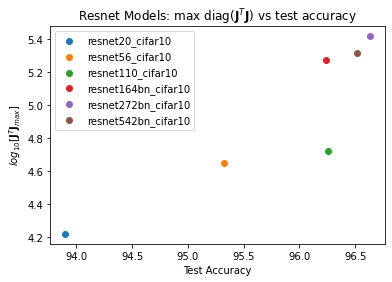

In [0]:
for name, acc, alpha, logJJmax in zip(modelnames, model_accs, model_alphas, model_maxlogJJs):
  print(name, acc, alpha)
  plt.scatter(acc, logJJmax, label=name)
plt.xlabel("Test Accuracy")
plt.ylabel(r"$log_{10}[\mathbf{J}^{T}\mathbf{J}_{max}]$")
plt.title(r"Resnet Models: max diag($\mathbf{J}^{T}\mathbf{J}$) vs test accuracy ")
plt.legend()

### Compute JJ for Test Data

### Ok.  Maybe look at the SVD ?